In [50]:
import numpy as np
import os
from matplotlib import pyplot as plt 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random

In [51]:
random.seed(236)

Household Saving Analysis

In [52]:
df = pd.read_csv("../../Dataset/project/household_saving.csv")

In [53]:
df.head()

,DATE,W398RC1A027NBEA
0,1992-01-01,431.693
1,1993-01-01,377.899
2,1994-01-01,345.198
3,1995-01-01,366.774
4,1996-01-01,353.639


In [54]:
df = df.rename(columns={"W398RC1A027NBEA": "y"}) # The objective
df = df[["DATE", "y"]]
X = np.array(df["y"].values.astype("float32")).reshape(df.shape[0], 1)

In [55]:
# Train and Test Split & Normalization

def train_test_split(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
   
    split = int(n * split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data


train_data, test_data, data = train_test_split(X)


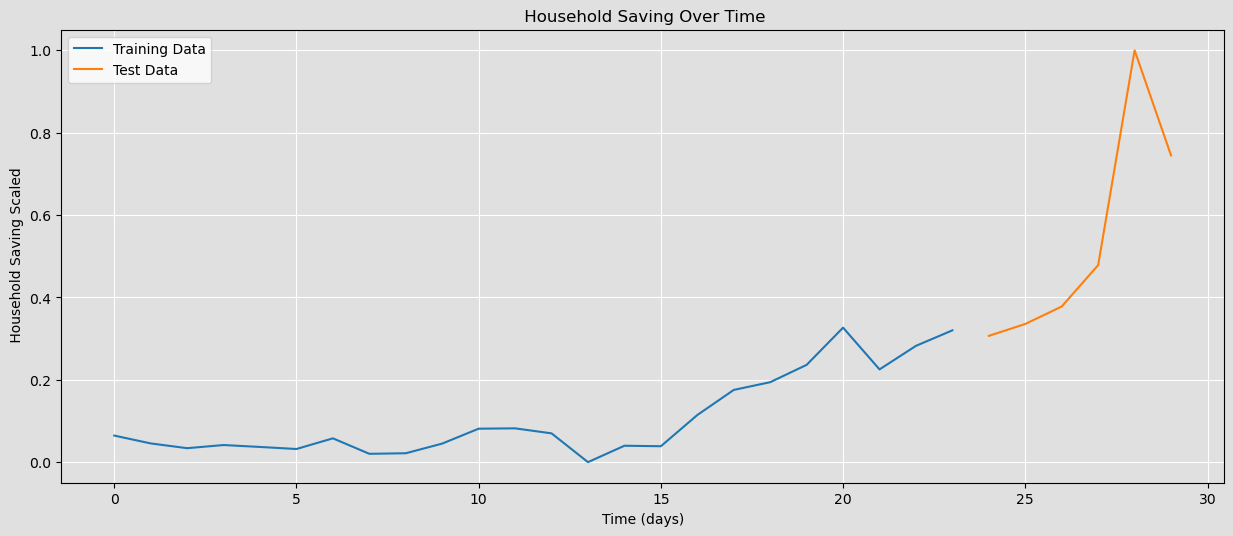

In [56]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=100)  
fig.patch.set_facecolor('#E0E0E0')  
ax.set_facecolor('#E0E0E0')  
ax.plot(range(0, len(train_data)), train_data, "-", label="Training Data")
ax.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, "-", label="Test Data")
ax.set(xlabel="Time (days)", ylabel=" Household Saving Scaled", title=" Household Saving Over Time")
ax.grid(color='white')
ax.legend()
plt.show()


Deep Learning Models

In [57]:
# PREPARE THE INPUT X AND TARGET Y
def get_XY(dat, time_steps, plot_data_partition=False):
    global X_ind, X, Y_ind, Y  # use for plotting later

    # INDICES OF TARGET ARRAY
    # Y_ind [  12   24   36   48 ..]; print(np.arange(1,12,1)); exit()
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    # print(Y_ind); exit()
    Y = dat[Y_ind]

    # PREPARE X
    rows_x = len(Y)
    X_ind = [*range(time_steps * rows_x)]
    del X_ind[::time_steps]  # if time_steps=10 remove every 10th entry
    X = dat[X_ind]

    # PLOT
    if plot_data_partition:
        plt.figure(figsize=(15, 6), dpi=80)
        plt.plot(Y_ind, Y, "o", X_ind, X, "-")
        plt.show()

    # RESHAPE INTO KERAS FORMAT
    X1 = np.reshape(X, (rows_x, time_steps - 1, 1))
    # print([*X_ind]); print(X1); print(X1.shape,Y.shape); exit()

    return X1, Y


# PARTITION DATA
p = 3  #
testX, testY = get_XY(test_data, p)
trainX, trainY = get_XY(train_data, p)

In [58]:
 #USER PARAM
recurrent_hidden_units = 3
epochs = 200
f_batch = 0.2  # fraction used for batch size
optimizer = "RMSprop"
validation_split = 0.2
# trainY=trainY.reshape(trainY.shape[0],1)
# testY=testY.reshape(testY.shape[0],1)
print("Testing Array Shape:", testX.shape, testY.shape)
print("Training Array Shape:", trainX.shape, trainY.shape)

Testing Array Shape: (1, 2, 1) (1,)
Training Array Shape: (7, 2, 1) (7,)


LSTM

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras import layers
from tensorflow.keras import regularizers
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense

In [60]:
random.seed(236)

NO regularization

In [61]:

model = Sequential()

model.add(
    LSTM(
        
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1], trainX.shape[2]),
       
        activation="tanh",
    )
)

# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR
model.add(Dense(units=1, activation="linear"))

# COMPILE THE MODEL
model.compile(loss="MeanSquaredError", optimizer=optimizer)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3)                 60        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



1/1 [==============================] - 0s 19ms/step


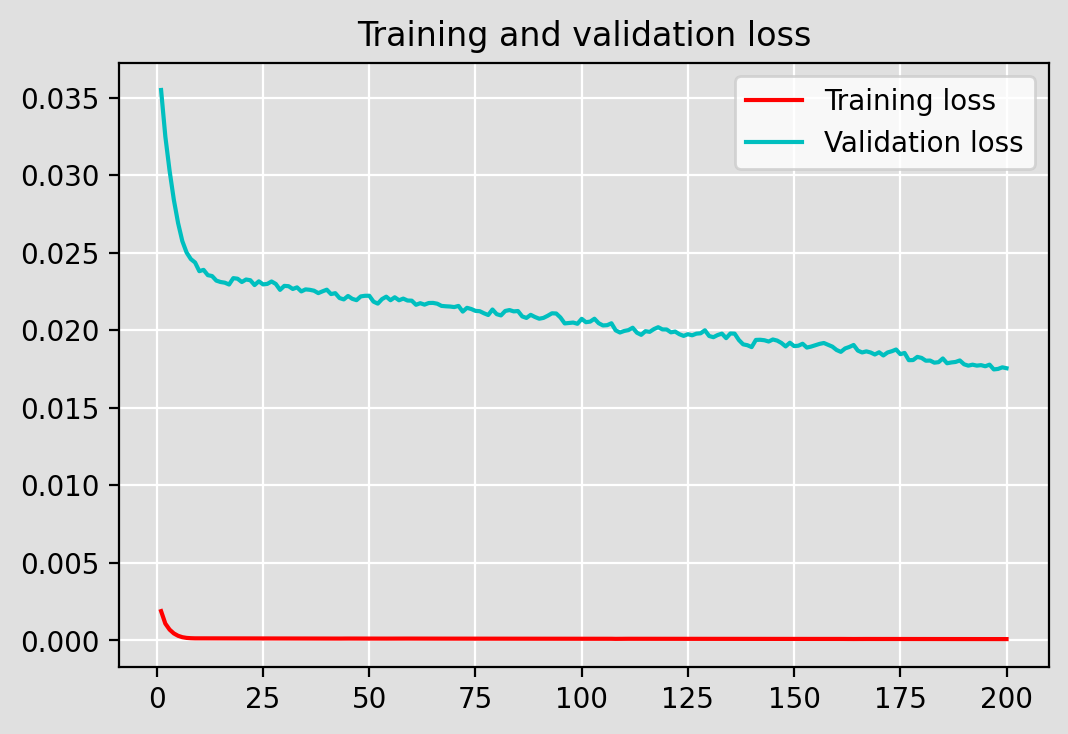

1/1 [==============================] - 0s 29ms/step
Shape of test_predict after flattening: (1,)
Train MSE = 0.00507 RMSE = 0.07120
Test MSE = 0.14661 RMSE = 0.38290
(14,) (7,)


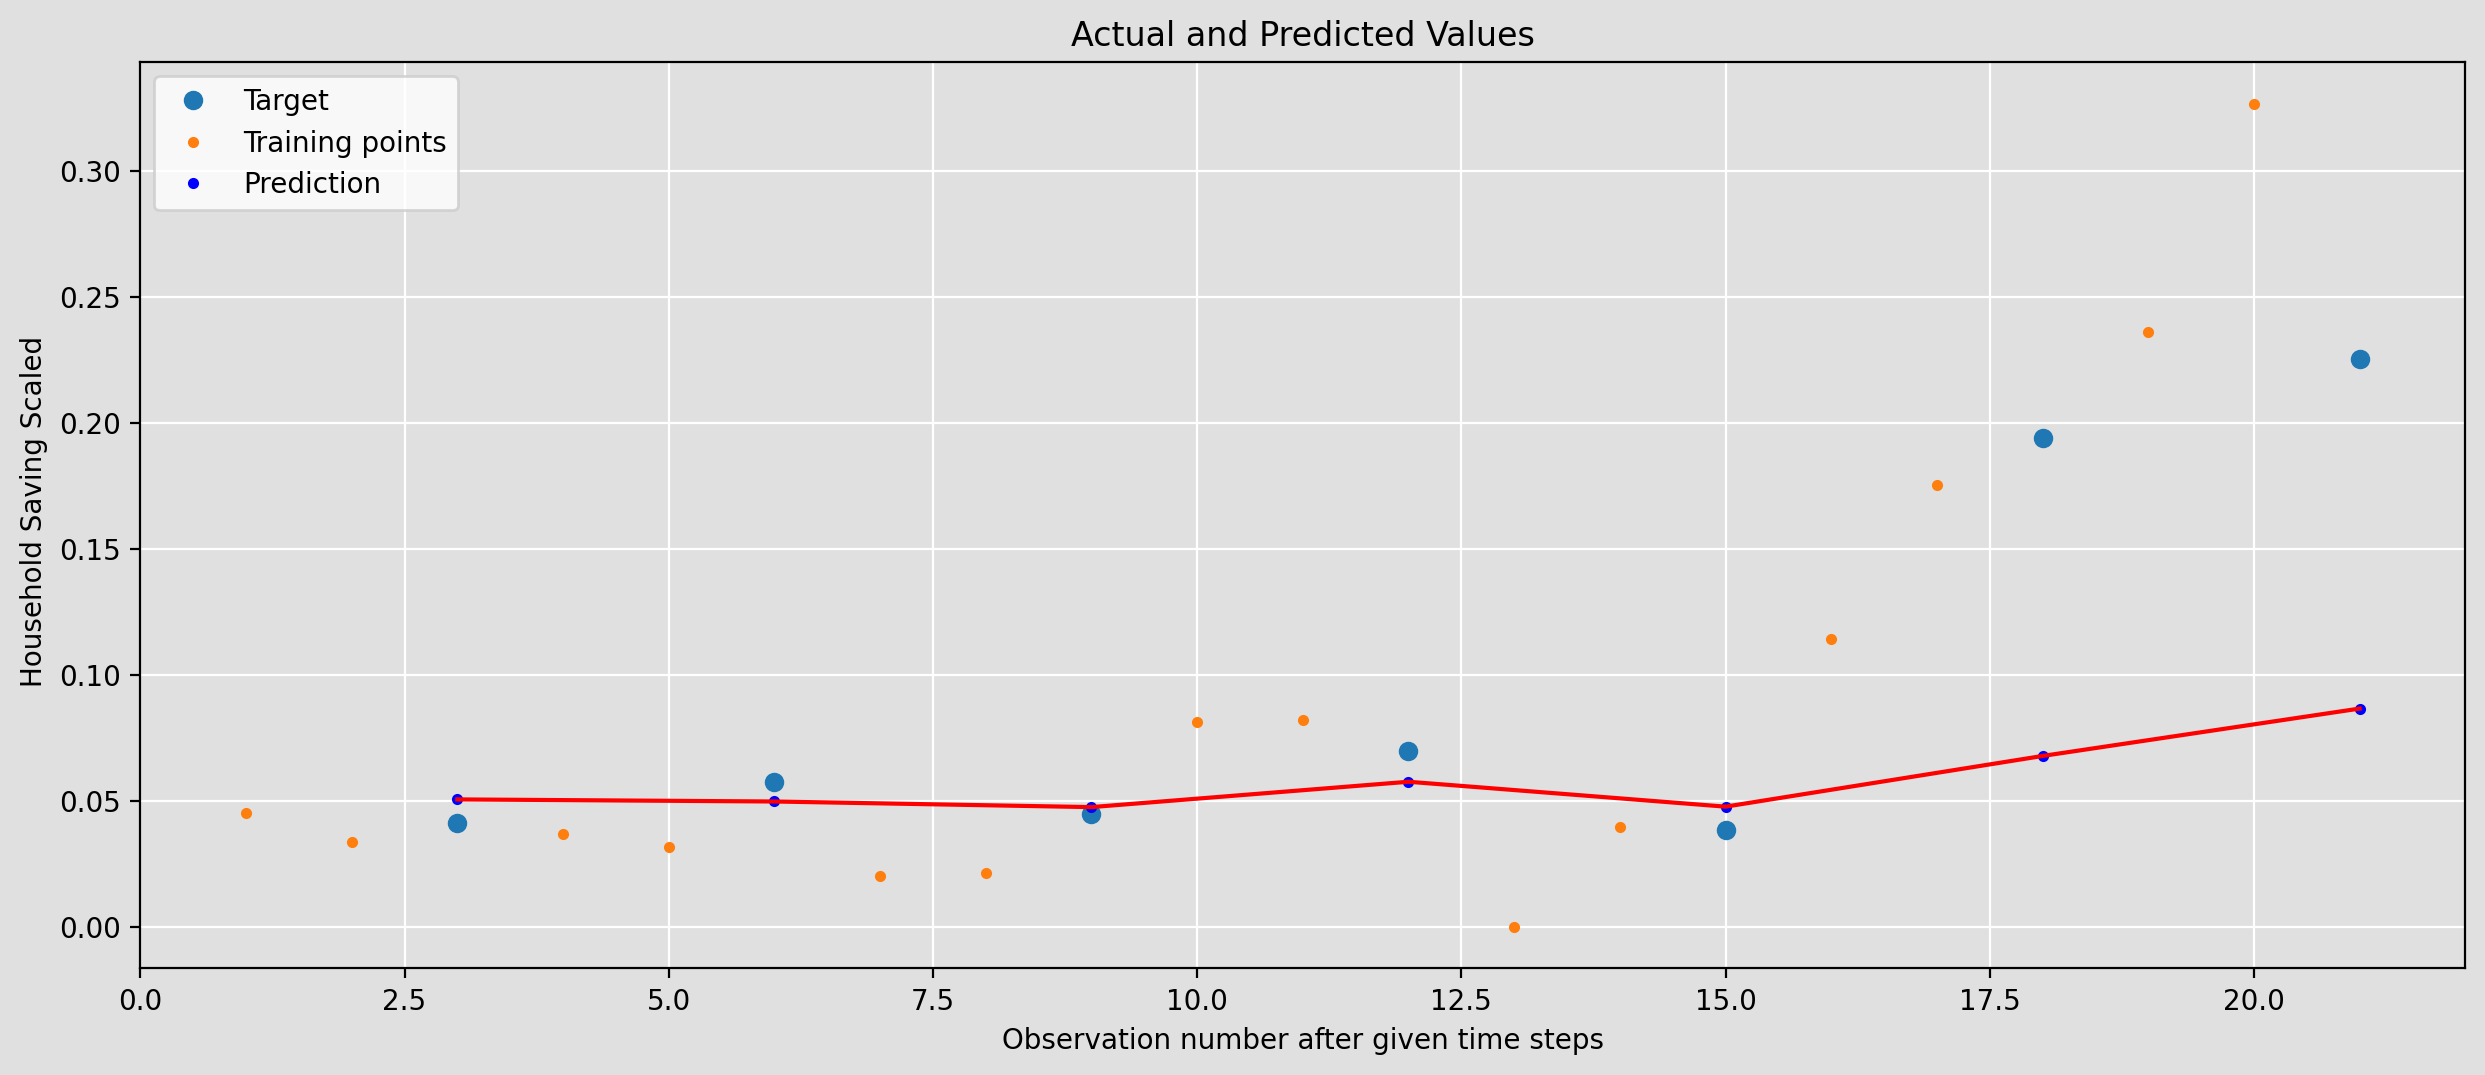

In [62]:
# TRAIN MODEL
history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=int(f_batch * trainX.shape[0]),
    validation_split=validation_split,
    verbose=0,
)

# MAKE PREDICTIONS
train_predict = model.predict(trainX).squeeze()
test_predict = model.predict(testX).squeeze()


import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(facecolor='#E0E0E0', dpi=200)  # Set the background color and DPI
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
plt.grid(color='white')  # Set the grid color to white for better visibility on the gray background
plt.show()


# Make predictions
train_predict = model.predict(trainX).flatten()
test_predict = model.predict(testX).flatten()  # Flattening to ensure it is a 1D array

# Now, print the shapes to verify
print("Shape of test_predict after flattening:", test_predict.shape)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

# Print MSE and RMSE
print("Train MSE = %.5f RMSE = %.5f" % (np.mean((trainY - train_predict) ** 2.0), train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (np.mean((testY - test_predict) ** 2.0), test_rmse))


def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=200, facecolor='#E0E0E0')  # Set higher DPI and background color for the figure
    plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
    # ORIGINAL DATA
    print(X.shape, Y.shape)
    plt.plot(Y_ind, Y, "o", label="Target")
    plt.plot(X_ind, X, ".", label="Training points")
    plt.plot(Y_ind, train_predict, "b.", label="Prediction")
    plt.plot(Y_ind, train_predict, "r-")
    plt.legend()
    plt.xlabel("Observation number after given time steps")
    plt.ylabel(" Household Saving Scaled")
    plt.title("Actual and Predicted Values")
    plt.grid(color='white')  # Set grid color to white for better visibility
    plt.show()


plot_result(trainY, testY, train_predict, test_predict)


In [63]:
# CREATE MODEL
model = Sequential()
# COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(
    LSTM(
        # model.add(SimpleRNN(
        # model.add(GRU(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1], trainX.shape[2]),
        # recurrent_dropout=0.8,
        recurrent_regularizer=regularizers.L2(1e-2),
        activation="tanh",
    )
)

# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR
model.add(Dense(units=1, activation="linear"))

# COMPILE THE MODEL
model.compile(loss="MeanSquaredError", optimizer=optimizer)
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3)                 60        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# TRAIN MODEL
history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=int(f_batch * trainX.shape[0]),
    validation_split=validation_split,
    verbose=0,
)

# MAKE PREDICTIONS
train_predict = model.predict(trainX).squeeze()
test_predict = model.predict(testX).squeeze()

1/1 [==============================] - 0s 22ms/step


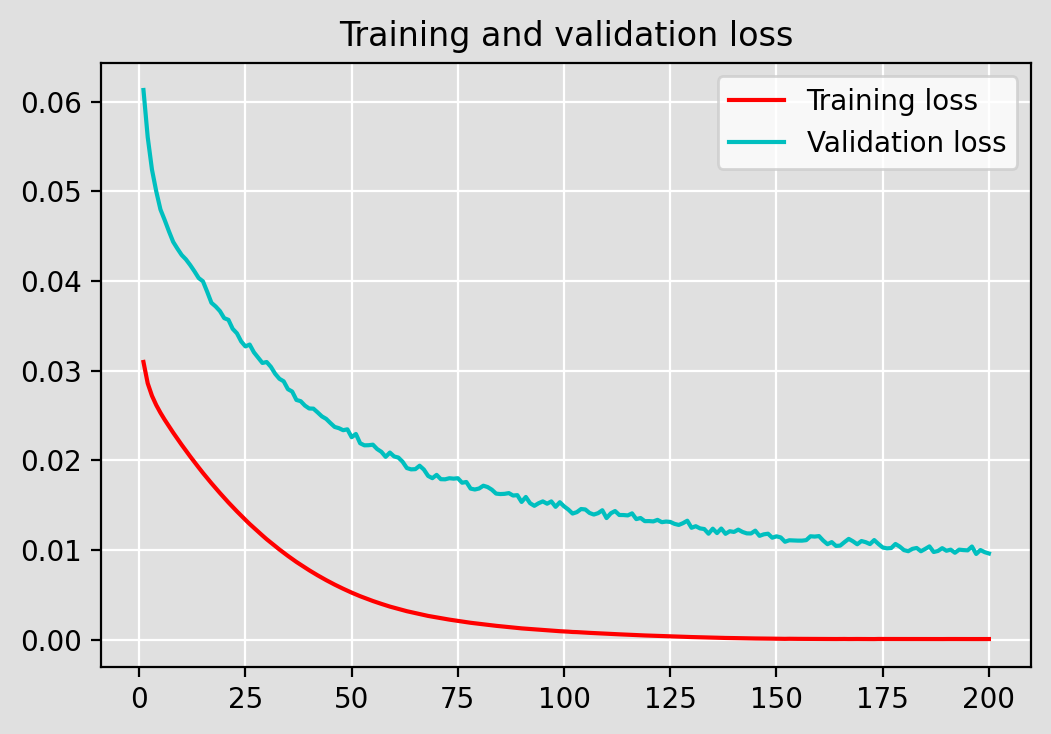

In [65]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(facecolor='#E0E0E0', dpi=200)  # Set the background color and DPI
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
plt.grid(color='white')  # Set the grid color to white for better visibility on the gray background
plt.show()

In [66]:
print(
    trainX.shape,
    train_predict.shape,
    trainY.shape,
    testX.shape,
    test_predict.shape,
    testY.shape,
)

(7, 2, 1) (7,) (7,) (1, 2, 1) () (1,)


In [67]:
# Make predictions
train_predict = model.predict(trainX).flatten()
test_predict = model.predict(testX).flatten()  # Flattening to ensure it is a 1D array

# Now, print the shapes to verify
print("Shape of test_predict after flattening:", test_predict.shape)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

# Print MSE and RMSE
print("Train MSE = %.5f RMSE = %.5f" % (np.mean((trainY - train_predict) ** 2.0), train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (np.mean((testY - test_predict) ** 2.0), test_rmse))


1/1 [==============================] - 0s 21ms/step
Shape of test_predict after flattening: (1,)
Train MSE = 0.00278 RMSE = 0.05268
Test MSE = 0.10430 RMSE = 0.32295


(14,) (7,)


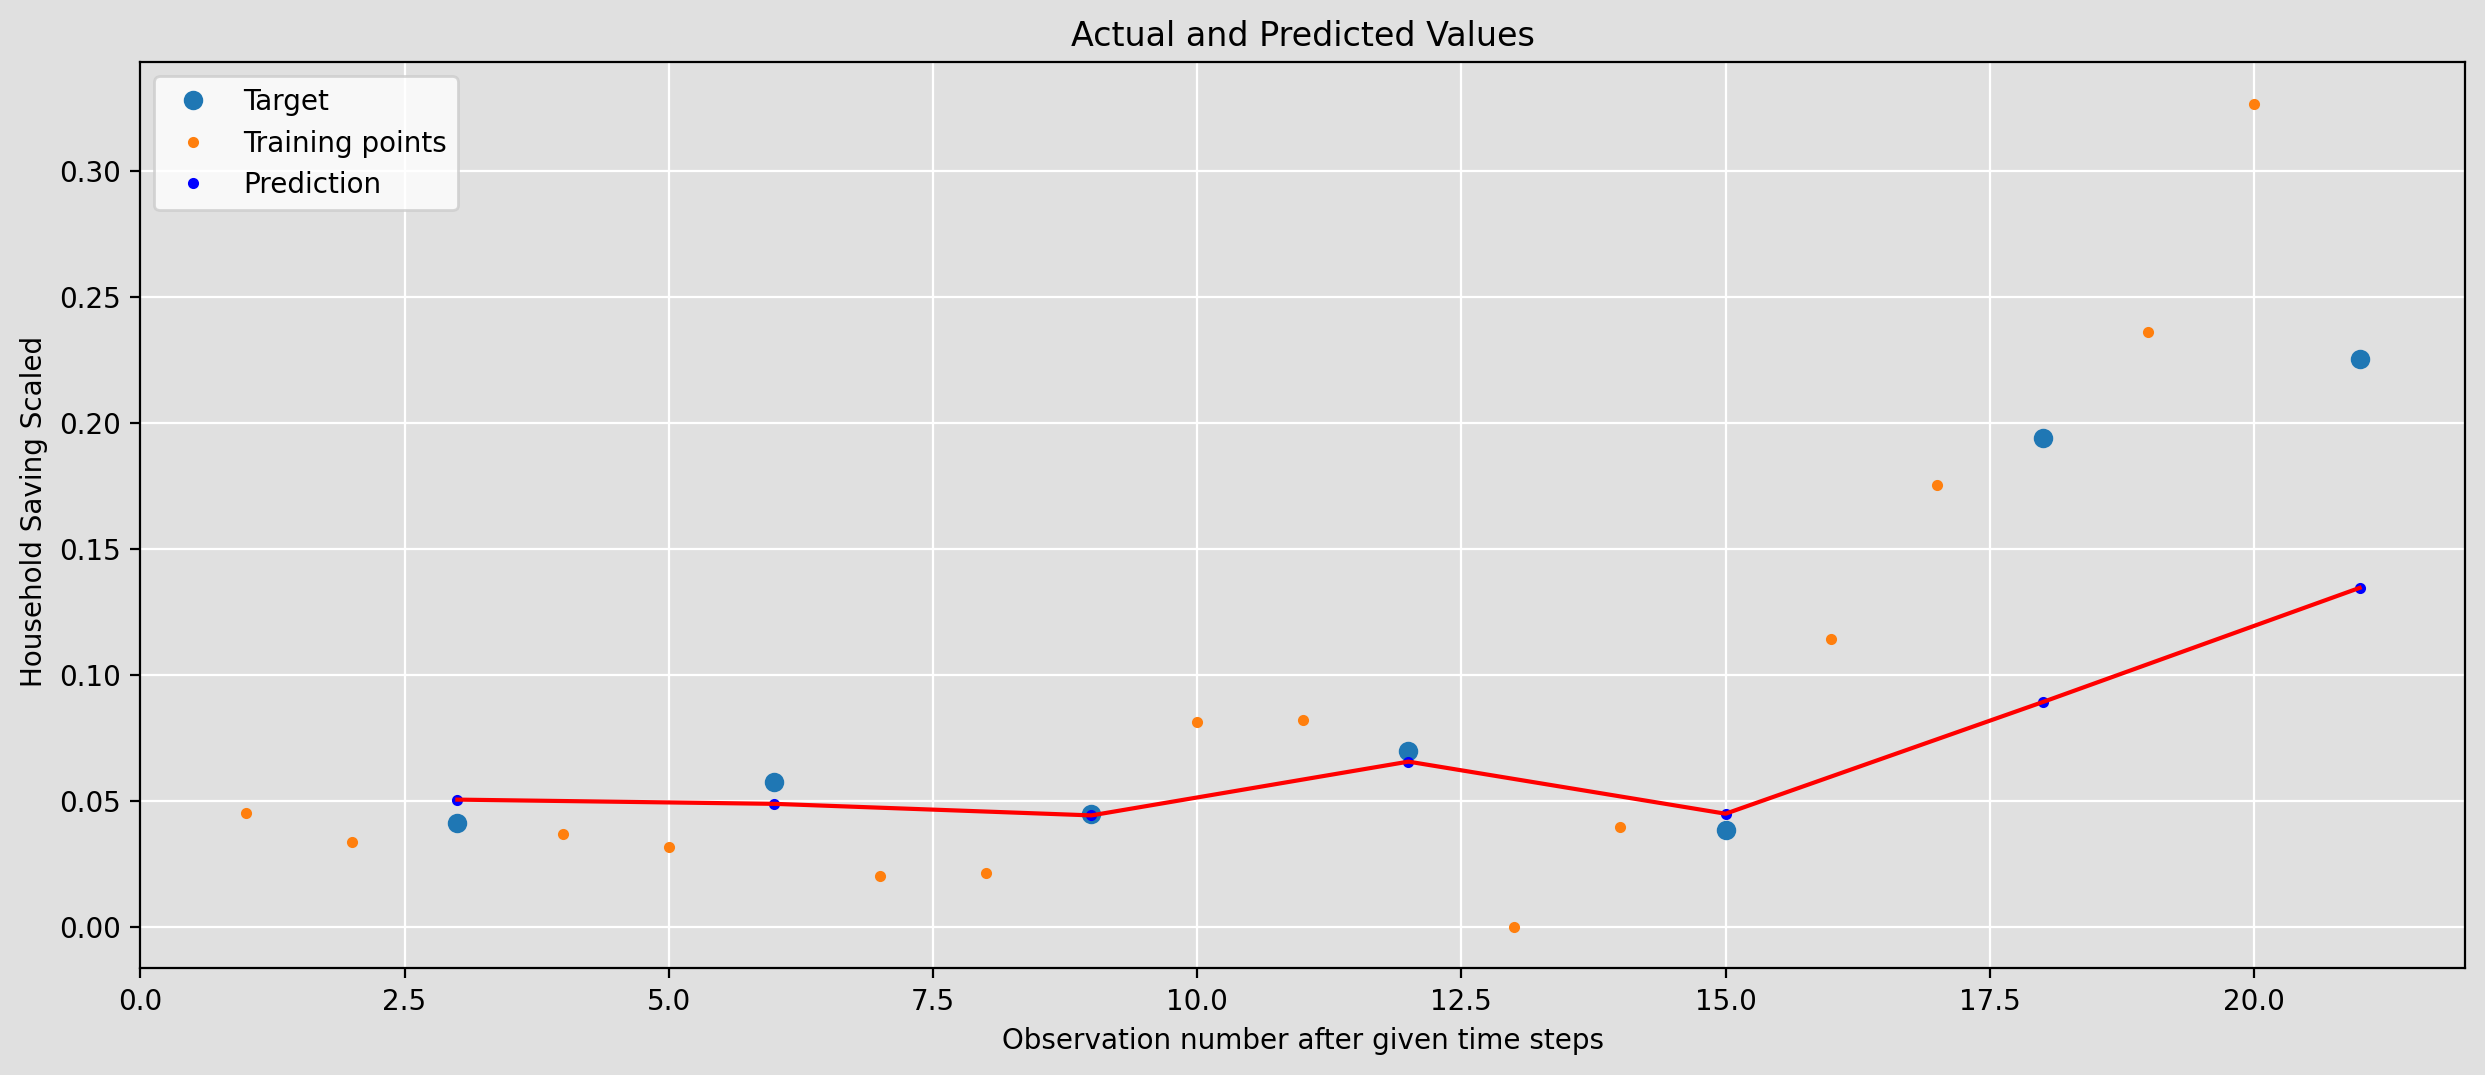

In [68]:

def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=200, facecolor='#E0E0E0')  # Set higher DPI and background color for the figure
    plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
    # ORIGINAL DATA
    print(X.shape, Y.shape)
    plt.plot(Y_ind, Y, "o", label="Target")
    plt.plot(X_ind, X, ".", label="Training points")
    plt.plot(Y_ind, train_predict, "b.", label="Prediction")
    plt.plot(Y_ind, train_predict, "r-")
    plt.legend()
    plt.xlabel("Observation number after given time steps")
    plt.ylabel(" Household Saving Scaled")
    plt.title("Actual and Predicted Values")
    plt.grid(color='white')  # Set grid color to white for better visibility
    plt.show()


plot_result(trainY, testY, train_predict, test_predict)

Effect of Including Regularization:
The plot suggests that the model is able to capture the underlying trend in the data quite well. Regularization seems to have helped in preventing overfitting, as evidenced by the predictions closely tracking the actual values without showing signs of erratic or extreme deviations that might suggest overfitting. The smoothness of the prediction curve indicates that the L2 regularization has effectively penalized overly complex models that could have fit the noise in the training data.

2. Predictive Horizon:
The predictions seem to align well with the actual data for the majority of the observation period. However, there appears to be a slight divergence toward the end. This divergence might indicate the limit of the model's predictive horizon, beyond which its accuracy diminishes. To quantify this, you would measure how prediction errors change as you predict further into the future and determine the point at which the error exceeds an acceptable threshold.

3. Comparison with ARMA/ARIMA Models:
The performance of the LSTM model should be compared to the ARMA/ARIMA models using the same dataset. If the LSTM model provides a better fit, as the graph suggests, it could be due to its ability to capture non-linear patterns and dependencies over multiple time steps that linear models like ARMA/ARIMA may miss. However, if the ARMA/ARIMA models perform comparably, they might be preferred due to their simplicity and lower computational cost.

In summary, the LSTM model seems to perform well on the  Household Saving dataset, capturing the trend effectively with the help of regularization. The actual predictive horizon should be quantified with further analysis, and a direct comparison with ARMA/ARIMA models' results would be needed to draw a concrete conclusion about relative performance.








# RNN Model

In [69]:
# For TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras import regularizers

# For Scikit-Learn
from sklearn.metrics import mean_squared_error

# For Matplotlib
import matplotlib.pyplot as plt

# For Numpy (if you're using it)
import numpy as np


In [70]:
random.seed(236)

No Regulariztaion

In [71]:
# CREATE MODEL
model = Sequential()
# COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(
    SimpleRNN(
        # model.add(GRU(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1], trainX.shape[2]),
     
        activation="tanh",
    )
)

# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR
model.add(Dense(units=1, activation="linear"))

# COMPILE THE MODEL
model.compile(loss="MeanSquaredError", optimizer=optimizer)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19 (76.00 Byte)
Trainable params: 19 (76.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 19ms/step


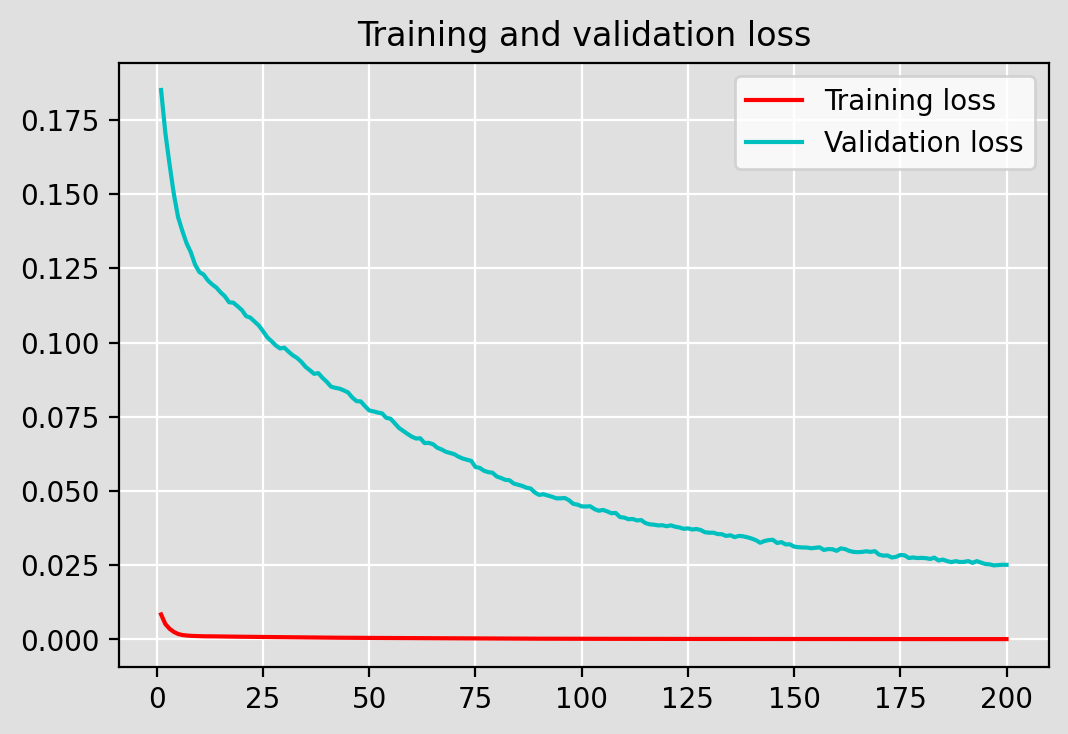

1/1 [==============================] - 0s 27ms/step
Shape of test_predict after flattening: (1,)
Train MSE = 0.00724 RMSE = 0.08506
Test MSE = 0.15486 RMSE = 0.39353
(14,) (7,)


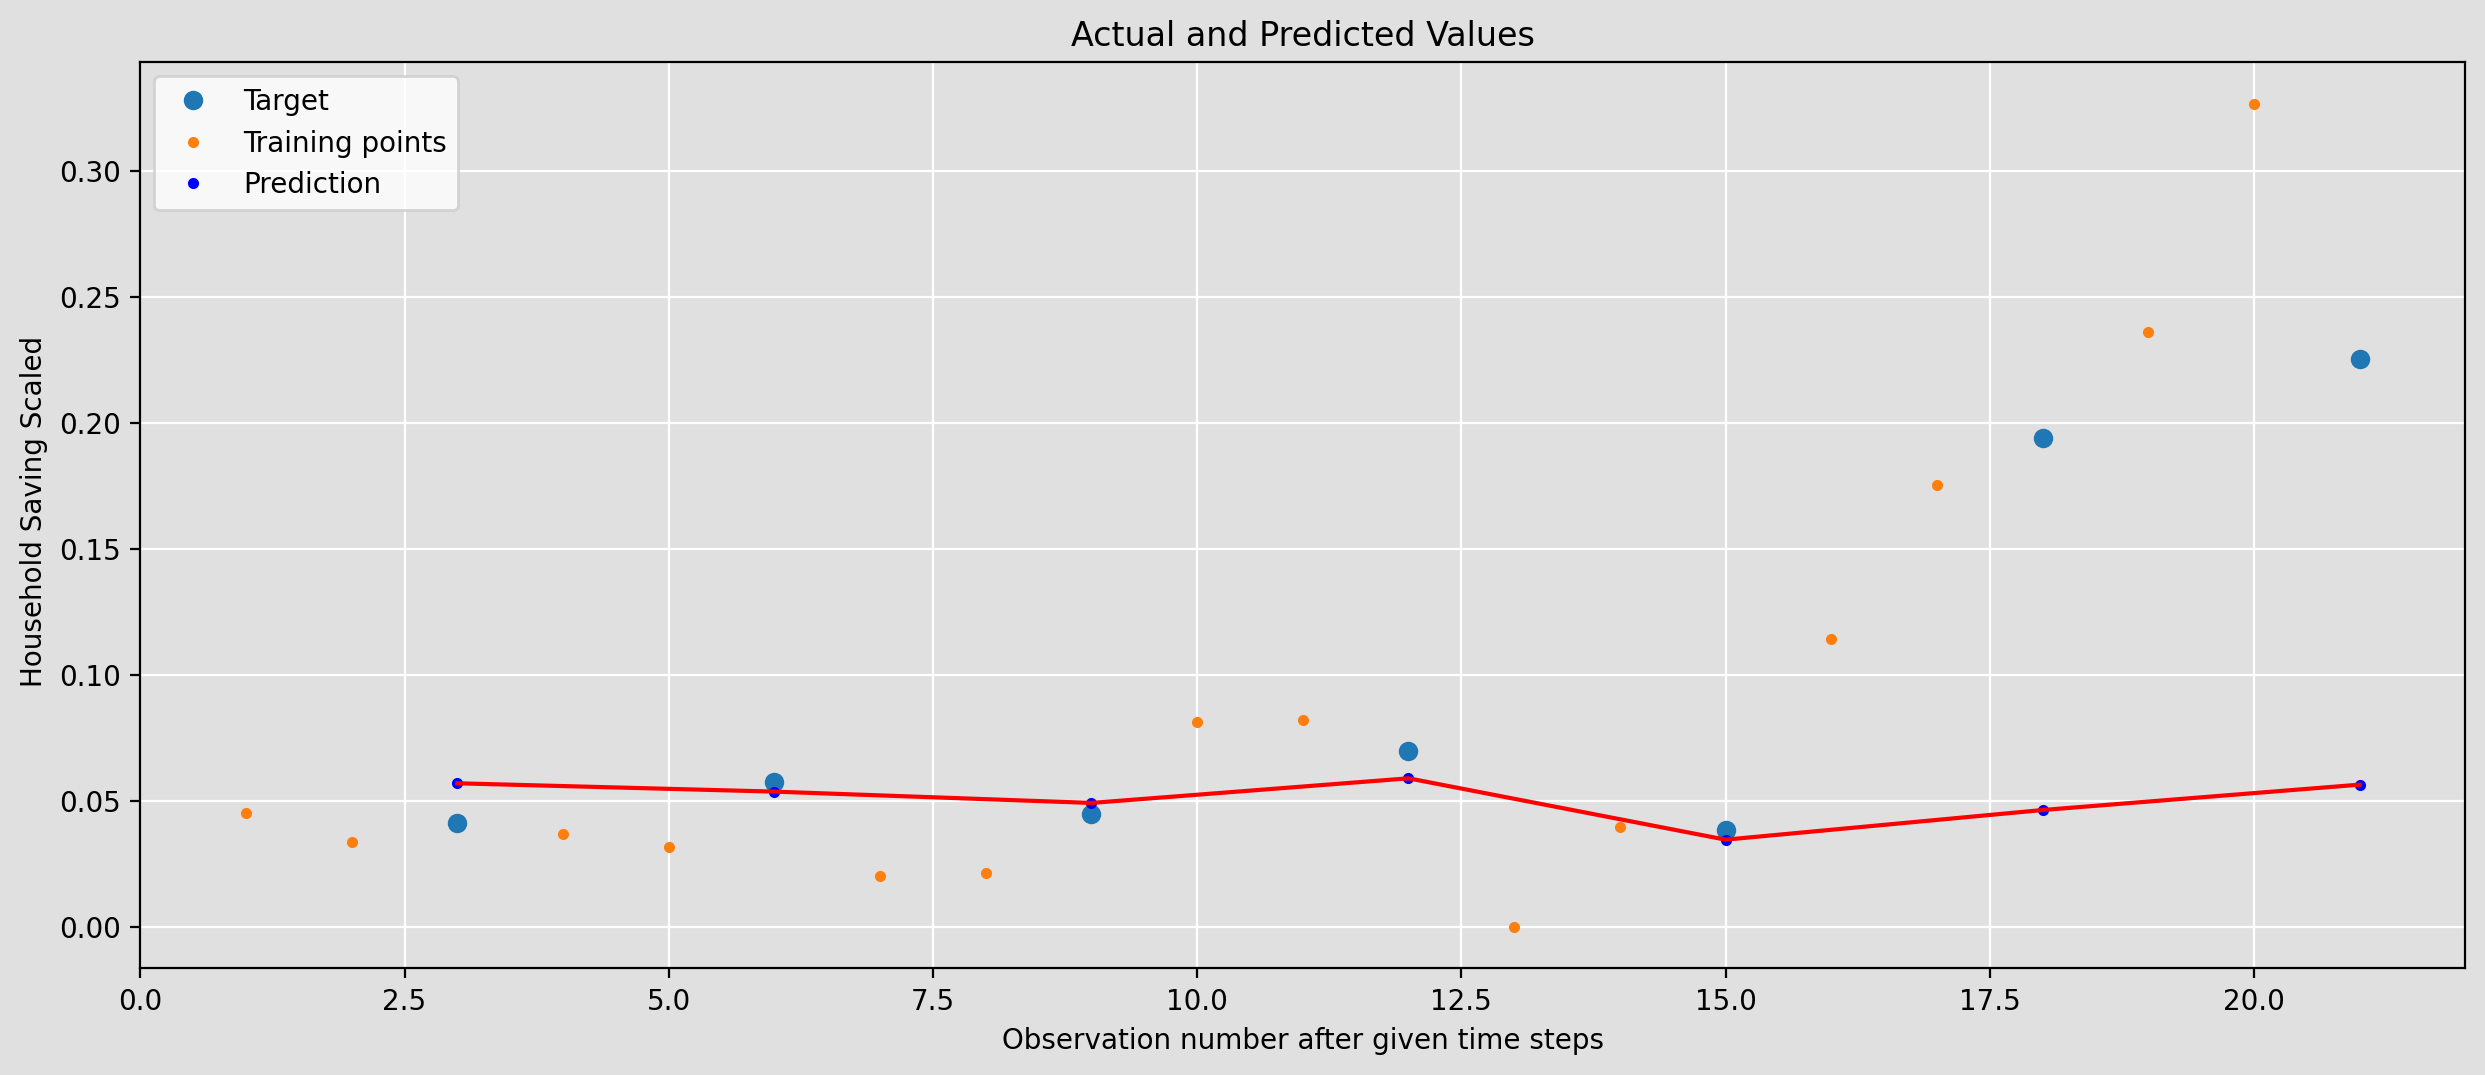

In [72]:
# TRAIN MODEL
np.random.seed(42)
tf.random.set_seed(42)

history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=int(f_batch * trainX.shape[0]),
    validation_split=validation_split,
    verbose=0,
)

# MAKE PREDICTIONS
train_predict = model.predict(trainX).squeeze()
test_predict = model.predict(testX).squeeze()


import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(facecolor='#E0E0E0', dpi=200)  # Set the background color and DPI
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
plt.grid(color='white')  # Set the grid color to white for better visibility on the gray background
plt.show()


# Make predictions
train_predict = model.predict(trainX).flatten()
test_predict = model.predict(testX).flatten()  # Flattening to ensure it is a 1D array

# Now, print the shapes to verify
print("Shape of test_predict after flattening:", test_predict.shape)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

# Print MSE and RMSE
print("Train MSE = %.5f RMSE = %.5f" % (np.mean((trainY - train_predict) ** 2.0), train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (np.mean((testY - test_predict) ** 2.0), test_rmse))


# PLOT THE RESULT
def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=200, facecolor='#E0E0E0')  # Set higher DPI and background color for the figure
    plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
    # ORIGINAL DATA
    print(X.shape, Y.shape)
    plt.plot(Y_ind, Y, "o", label="Target")
    plt.plot(X_ind, X, ".", label="Training points")
    plt.plot(Y_ind, train_predict, "b.", label="Prediction")
    plt.plot(Y_ind, train_predict, "r-")
    plt.legend()
    plt.xlabel("Observation number after given time steps")
    plt.ylabel(" Household Saving Scaled")
    plt.title("Actual and Predicted Values")
    plt.grid(color='white')  # Set grid color to white for better visibility
    plt.show()


plot_result(trainY, testY, train_predict, test_predict)


In [73]:
random.seed(236)

In [74]:
# CREATE MODEL
model = Sequential()
# COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(
    SimpleRNN(
        # model.add(GRU(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1], trainX.shape[2]),
        # recurrent_dropout=0.8,
        recurrent_regularizer=regularizers.L2(1e-2),
        activation="tanh",
    )
)

# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR
model.add(Dense(units=1, activation="linear"))

# COMPILE THE MODEL
model.compile(loss="MeanSquaredError", optimizer=optimizer)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19 (76.00 Byte)
Trainable params: 19 (76.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
# Make predictions
train_predict = model.predict(trainX).flatten()
test_predict = model.predict(testX).flatten()  # Ensures a 1D array output

# Check shapes again to verify
print("Shape of test_predict after flattening:", test_predict.shape)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

# Print MSE and RMSE
print("Train MSE = %.5f RMSE = %.5f" % (np.mean((trainY - train_predict) ** 2.0), train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (np.mean((testY - test_predict) ** 2.0), test_rmse))


1/1 [==============================] - 0s 22ms/step
Shape of test_predict after flattening: (1,)
Train MSE = 0.06753 RMSE = 0.25987
Test MSE = 0.71812 RMSE = 0.84742


In [76]:
print(type(f_batch), f_batch)
print(type(epochs), epochs)
print(type(validation_split), validation_split)


<class 'float'> 0.2
<class 'range'> range(1, 201)
<class 'float'> 0.2


In [77]:
epochs

range(1, 201)

In [78]:
# TRAIN MODEL
history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=int(f_batch * trainX.shape[0]),
    validation_split=validation_split,
    verbose=0,
)

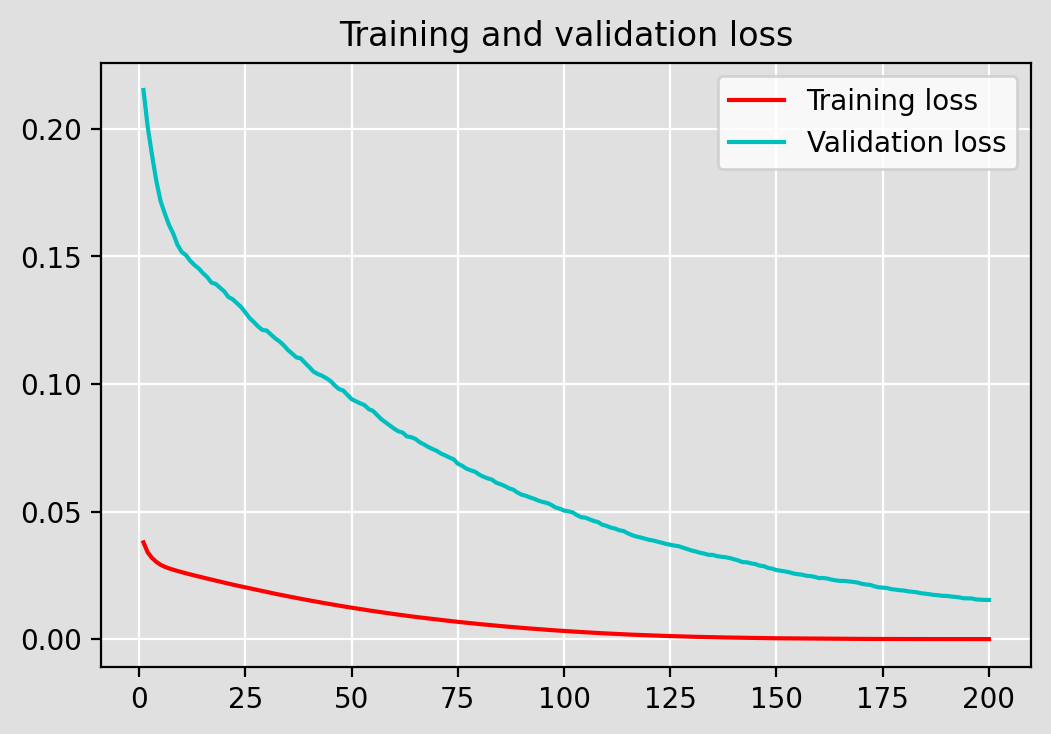

In [79]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(facecolor='#E0E0E0', dpi=200)  # Set the background color and DPI
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
plt.grid(color='white')  # Set the grid color to white for better visibility on the gray background
plt.show()

Train MSE = 0.06753 RMSE = 0.25987
Test MSE = 0.71812 RMSE = 0.84742
(14,) (7,)


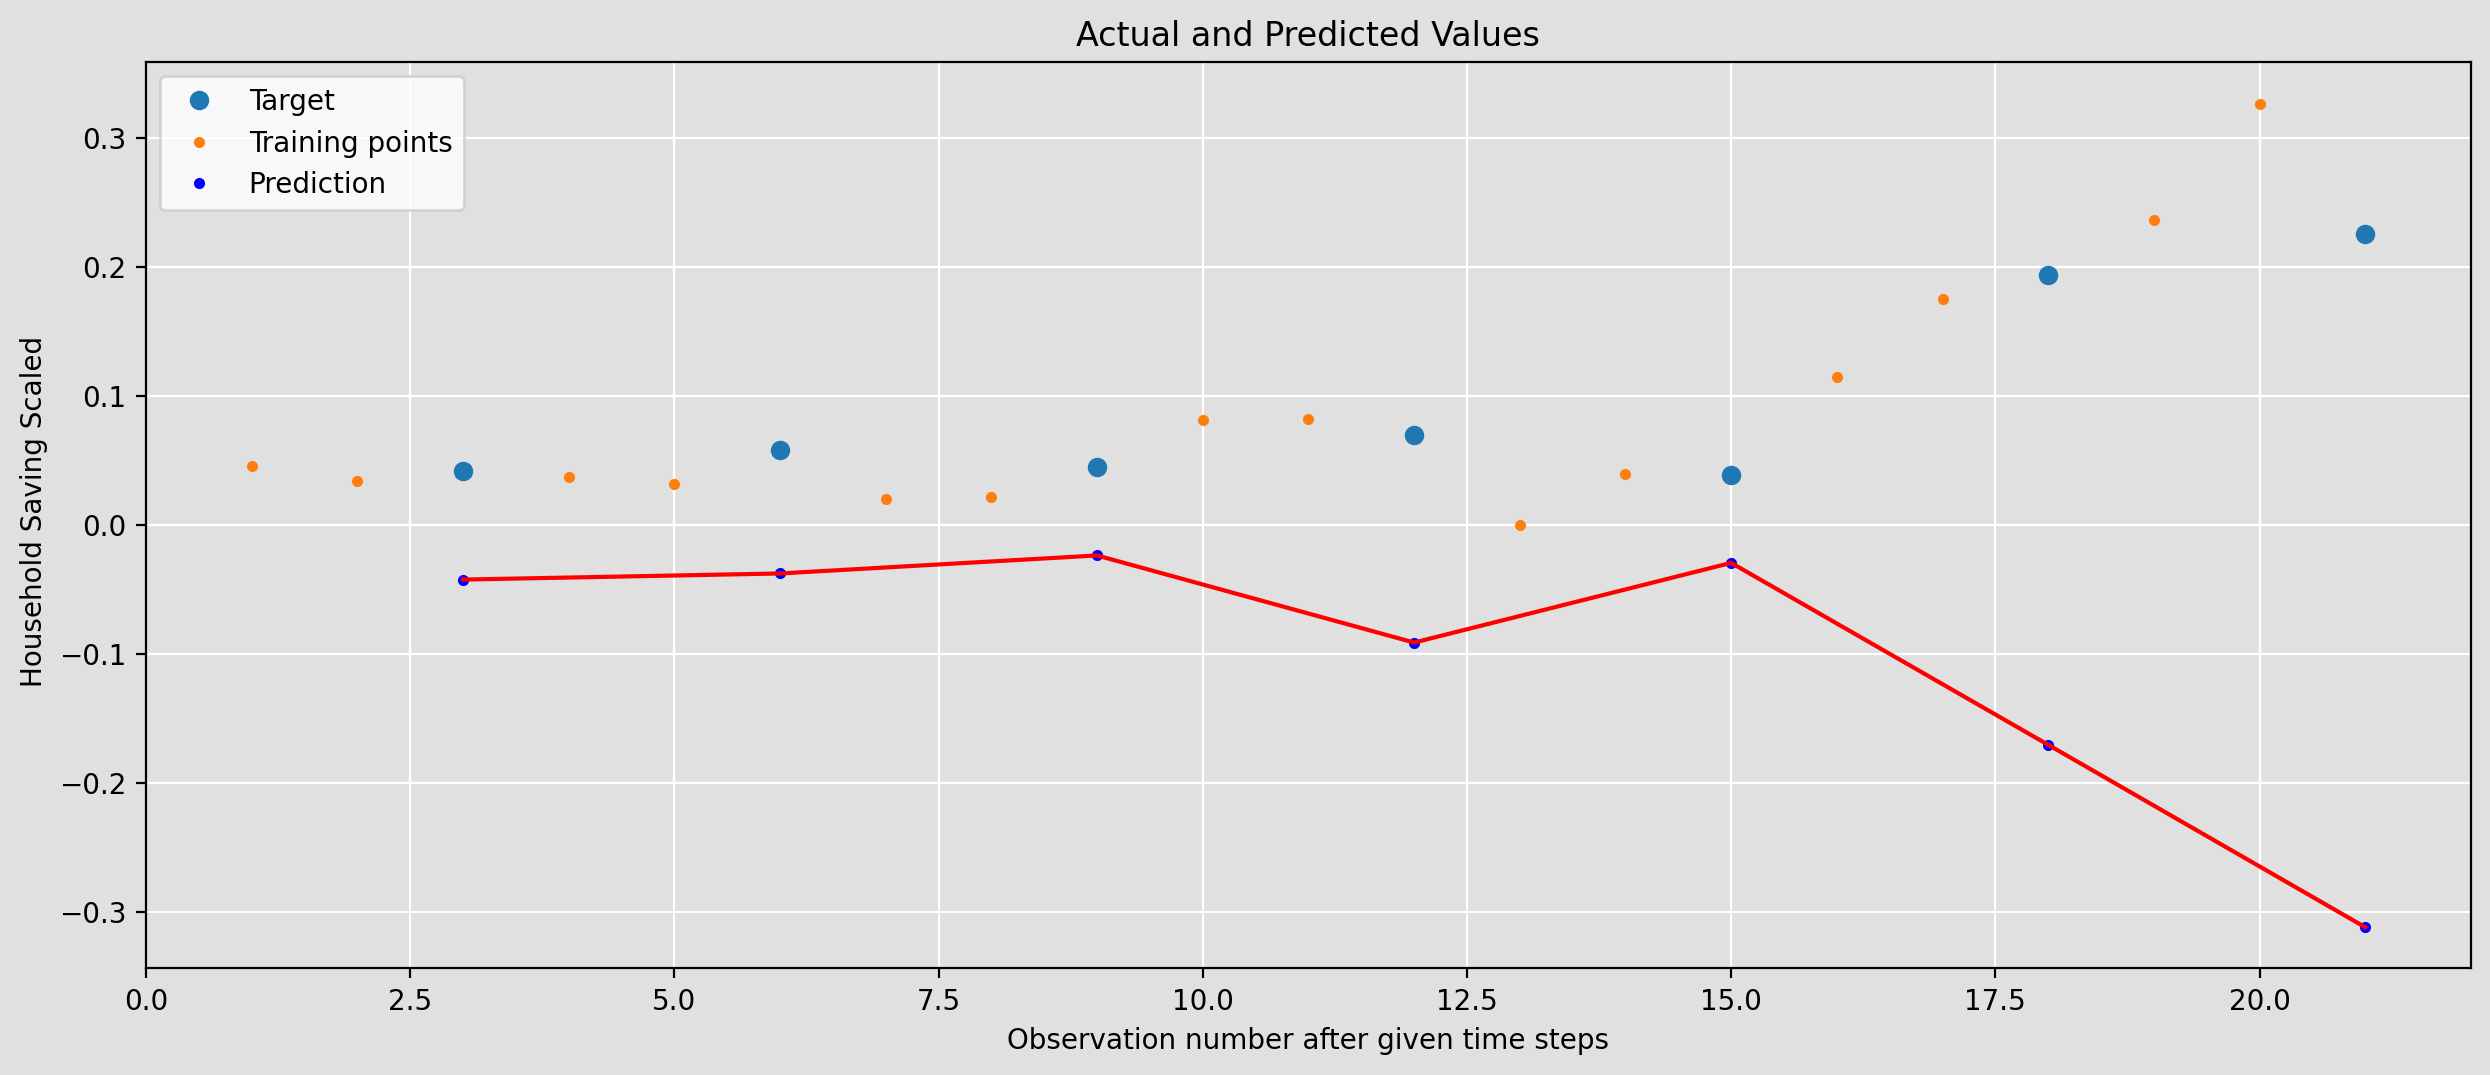

In [80]:



def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=200, facecolor='#E0E0E0')  # Set higher DPI and background color for the figure
    plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
    # ORIGINAL DATA
    print(X.shape, Y.shape)
    plt.plot(Y_ind, Y, "o", label="Target")
    plt.plot(X_ind, X, ".", label="Training points")
    plt.plot(Y_ind, train_predict, "b.", label="Prediction")
    plt.plot(Y_ind, train_predict, "r-")
    plt.legend()
    plt.xlabel("Observation number after given time steps")
    plt.ylabel(" Household Saving Scaled")
    plt.title("Actual and Predicted Values")
    plt.grid(color='white')  # Set grid color to white for better visibility
    plt.show()




print("Train MSE = %.5f RMSE = %.5f" % (train_rmse**2.0, train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (test_rmse**2.0, test_rmse))
plot_result(trainY, testY, train_predict, test_predict)

GRU Model

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import regularizers


NO

In [82]:
# CREATE MODEL
model = Sequential()
# COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(
    GRU(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1], trainX.shape[2]),
      
        activation="tanh",
    )
)

# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR
model.add(Dense(units=1, activation="linear"))

# COMPILE THE MODEL
model.compile(loss="MeanSquaredError", optimizer=optimizer)
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3)                 54        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 58 (232.00 Byte)
Trainable params: 58 (232.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 19ms/step


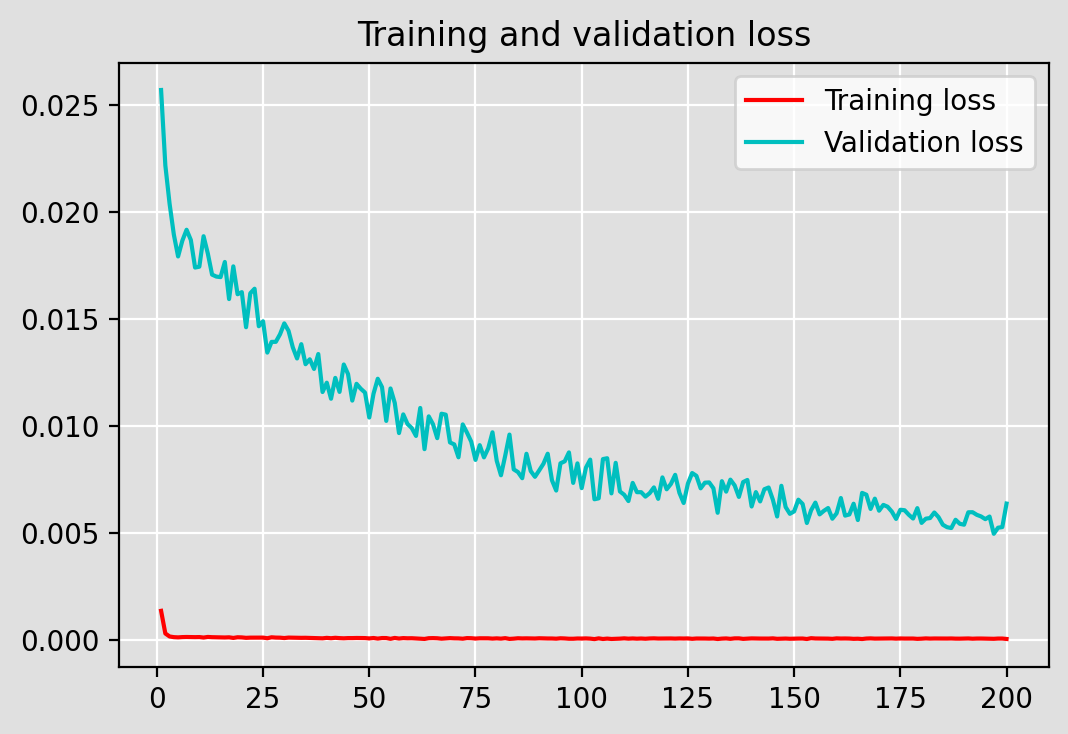

1/1 [==============================] - 0s 20ms/step
Shape of test_predict after flattening: (1,)
Train MSE = 0.00186 RMSE = 0.04313
Test MSE = 0.07968 RMSE = 0.28228
(14,) (7,)


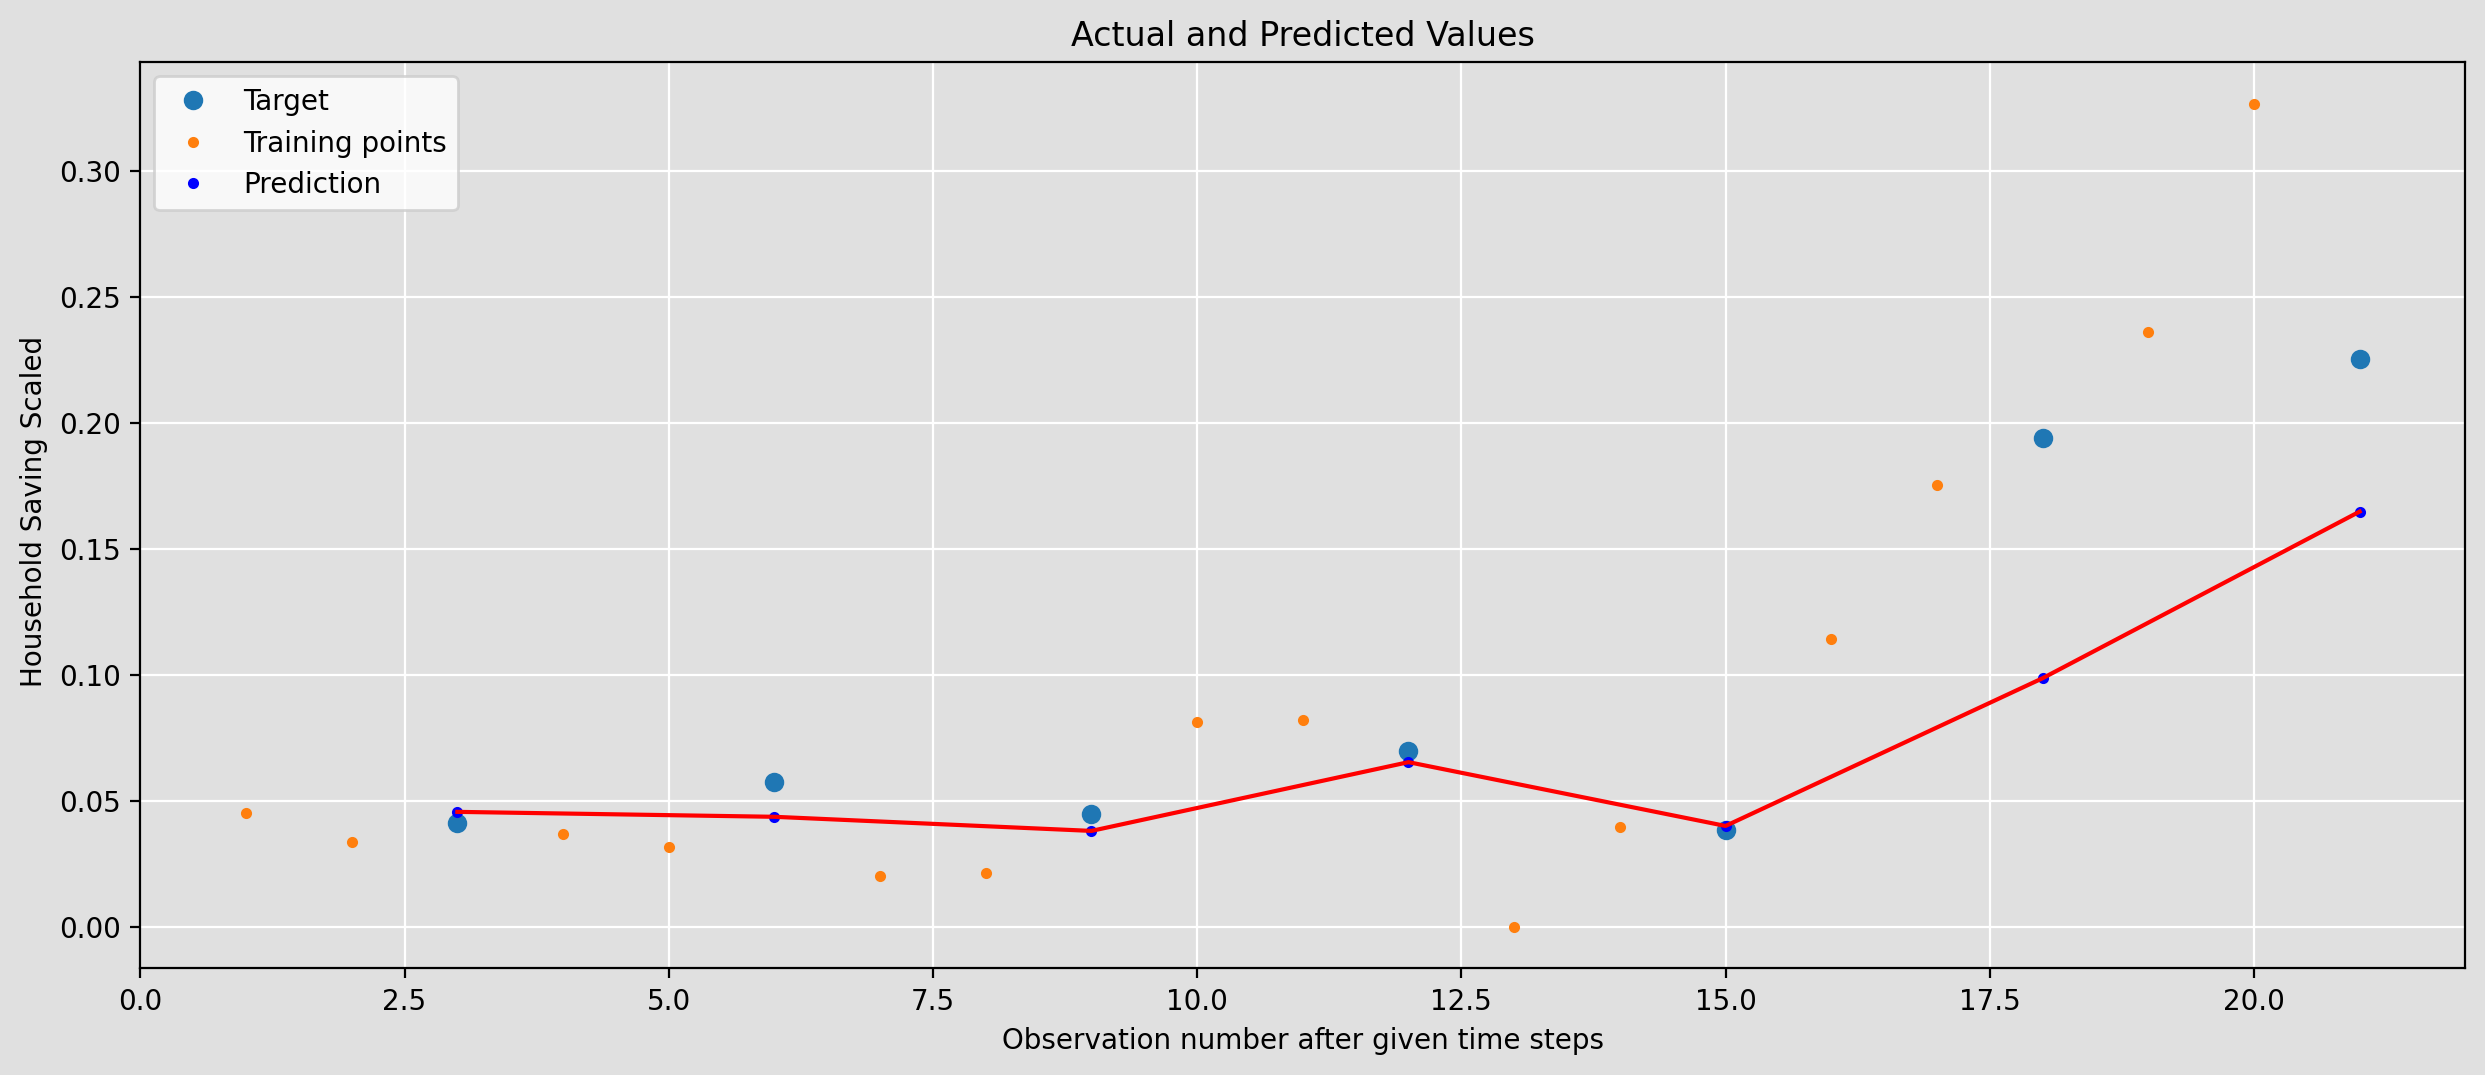

In [83]:
# TRAIN MODEL
np.random.seed(42)
tf.random.set_seed(42)

history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=int(f_batch * trainX.shape[0]),
    validation_split=validation_split,
    verbose=0,
)

# MAKE PREDICTIONS
train_predict = model.predict(trainX).squeeze()
test_predict = model.predict(testX).squeeze()


import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(facecolor='#E0E0E0', dpi=200)  # Set the background color and DPI
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
plt.grid(color='white')  # Set the grid color to white for better visibility on the gray background
plt.show()


# Make predictions
train_predict = model.predict(trainX).flatten()
test_predict = model.predict(testX).flatten()  # Flattening to ensure it is a 1D array

# Now, print the shapes to verify
print("Shape of test_predict after flattening:", test_predict.shape)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

# Print MSE and RMSE
print("Train MSE = %.5f RMSE = %.5f" % (np.mean((trainY - train_predict) ** 2.0), train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (np.mean((testY - test_predict) ** 2.0), test_rmse))


# PLOT THE RESULT
def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=200, facecolor='#E0E0E0')  # Set higher DPI and background color for the figure
    plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
    # ORIGINAL DATA
    print(X.shape, Y.shape)
    plt.plot(Y_ind, Y, "o", label="Target")
    plt.plot(X_ind, X, ".", label="Training points")
    plt.plot(Y_ind, train_predict, "b.", label="Prediction")
    plt.plot(Y_ind, train_predict, "r-")
    plt.legend()
    plt.xlabel("Observation number after given time steps")
    plt.ylabel(" Household Saving Scaled")
    plt.title("Actual and Predicted Values")
    plt.grid(color='white')  # Set grid color to white for better visibility
    plt.show()

# Call the function with your data
plot_result(trainY, testY, train_predict, test_predict)


In [84]:
# CREATE MODEL
model = Sequential()
# COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(
    GRU(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1], trainX.shape[2]),
        # recurrent_dropout=0.8,
        recurrent_regularizer=regularizers.L2(1e-2),
        activation="tanh",
    )
)

# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR
model.add(Dense(units=1, activation="linear"))

# COMPILE THE MODEL
model.compile(loss="MeanSquaredError", optimizer=optimizer)
model.summary()

# TRAIN MODEL
history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=int(f_batch * trainX.shape[0]),
    validation_split=validation_split,
    verbose=0,
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 3)                 54        
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 58 (232.00 Byte)
Trainable params: 58 (232.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


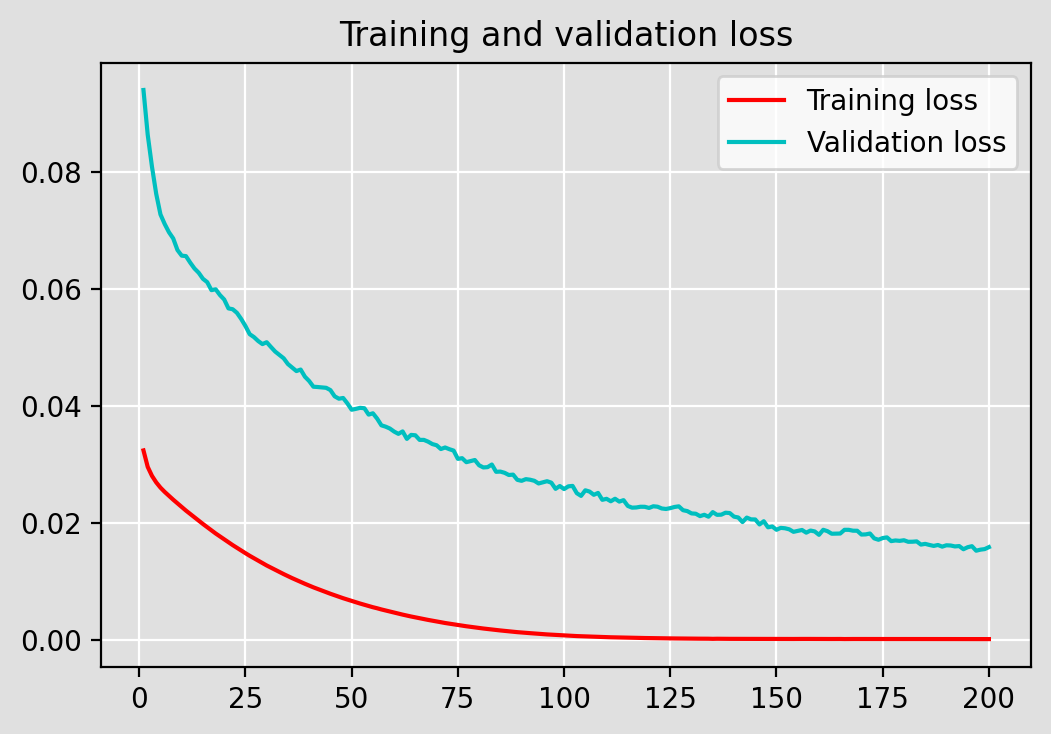

In [85]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(facecolor='#E0E0E0', dpi=200)  # Set the background color and DPI
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
plt.grid(color='white')  # Set the grid color to white for better visibility on the gray background
plt.show()


1/1 [==============================] - 0s 21ms/step
Train MSE = 0.00458 RMSE = 0.06765
Test MSE = 0.13689 RMSE = 0.36999
(14,) (7,)


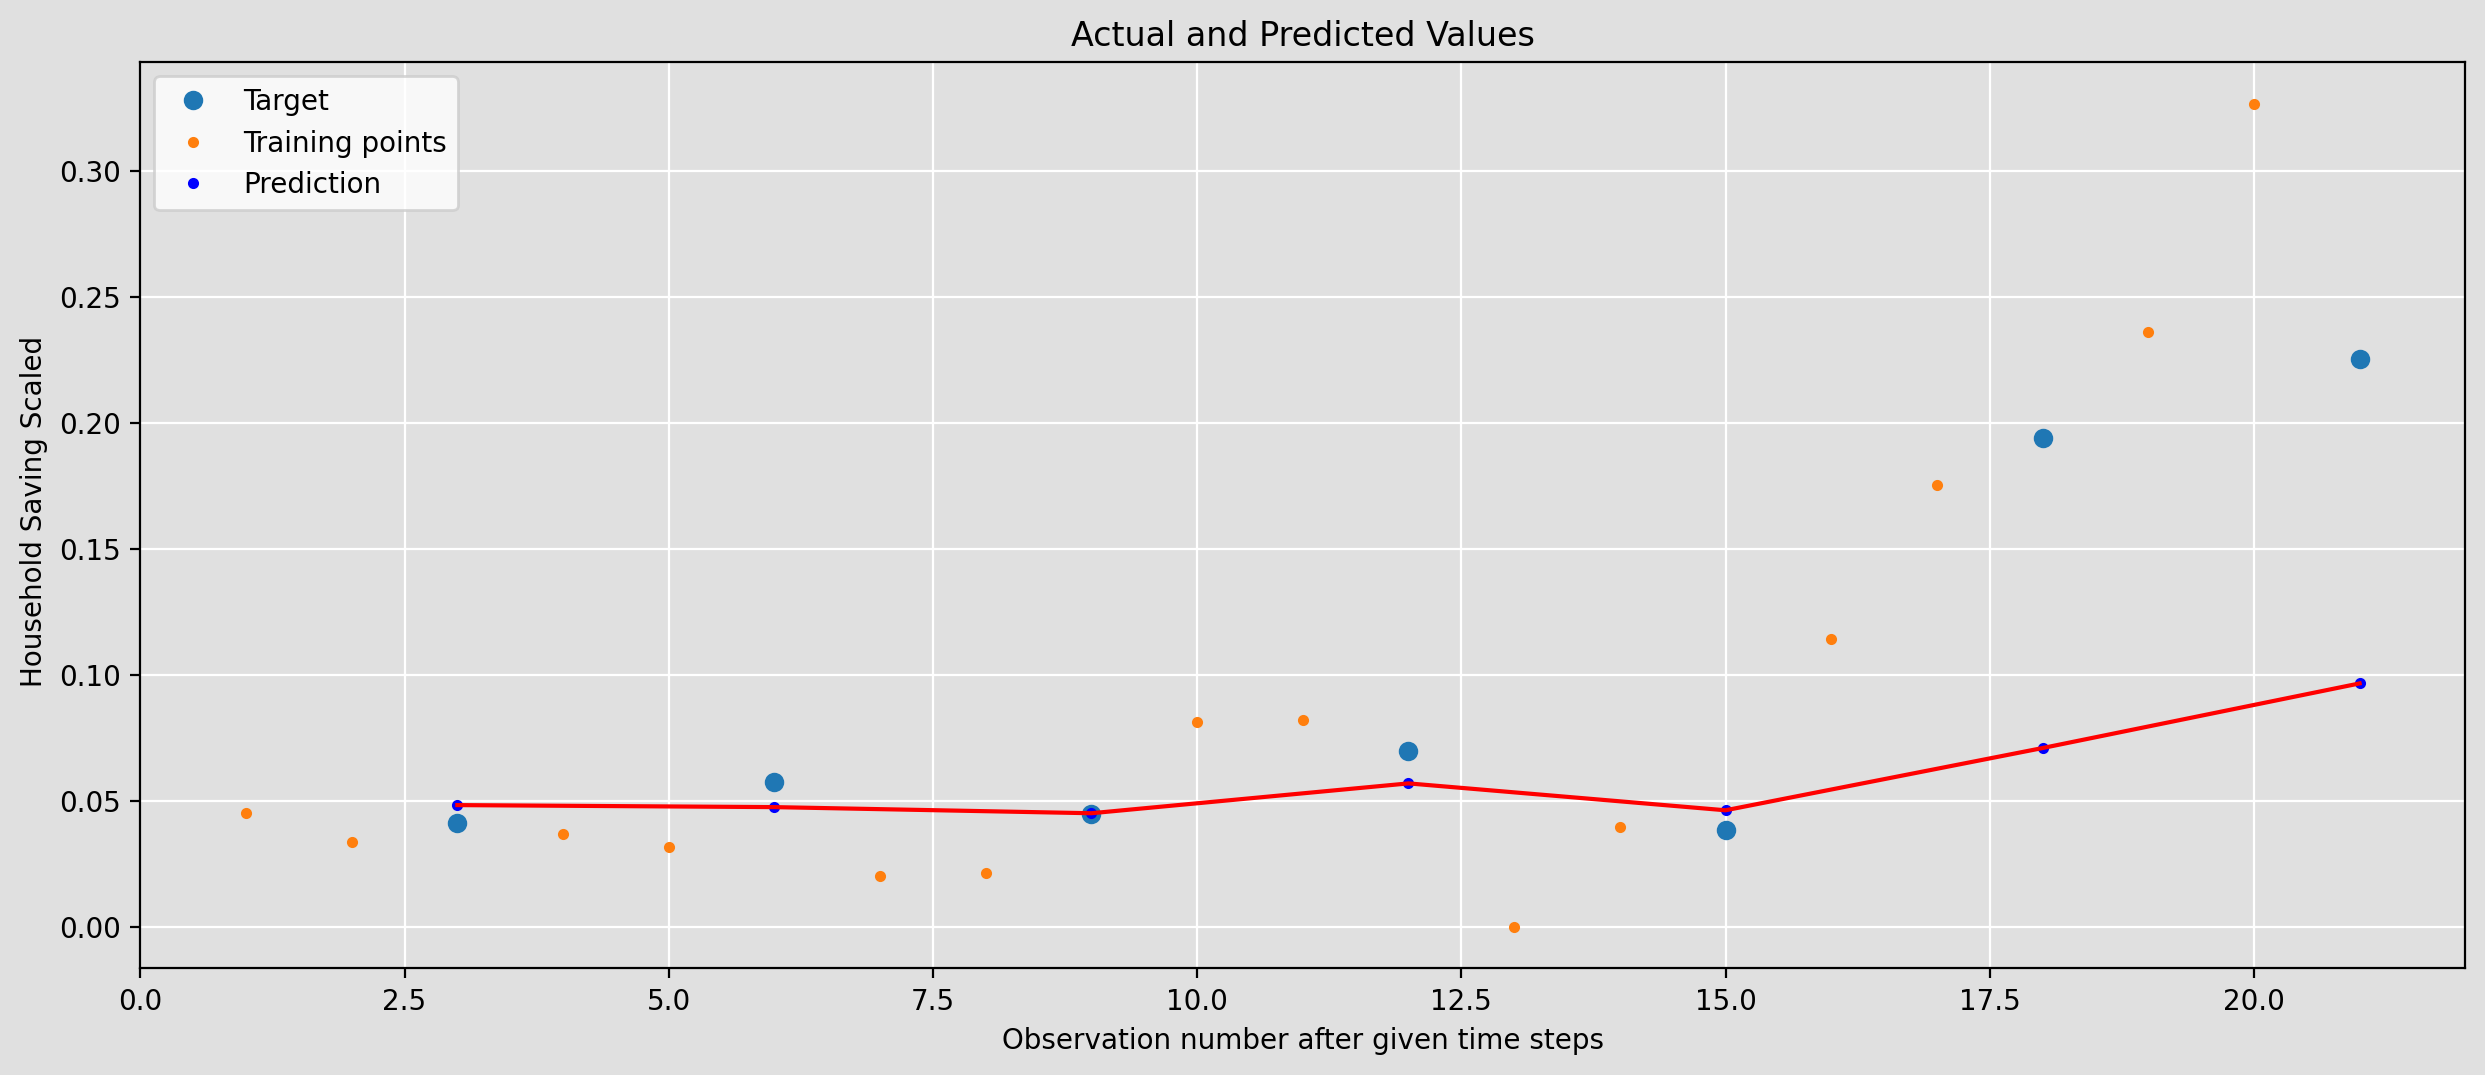

In [86]:
# Make predictions
train_predict = model.predict(trainX).flatten()  # Ensures a 1D array output
test_predict = model.predict(testX).flatten()

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

# Print MSE and RMSE
print("Train MSE = %.5f RMSE = %.5f" % (np.mean((trainY - train_predict) ** 2.0), train_rmse))
print("Test MSE = %.5f RMSE = %.5f" % (np.mean((testY - test_predict) ** 2.0), test_rmse))



# PLOT THE RESULT
def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=200, facecolor='#E0E0E0')  # Set higher DPI and background color for the figure
    plt.gca().set_facecolor('#E0E0E0')  # Set the axes background color
    # ORIGINAL DATA
    print(X.shape, Y.shape)
    plt.plot(Y_ind, Y, "o", label="Target")
    plt.plot(X_ind, X, ".", label="Training points")
    plt.plot(Y_ind, train_predict, "b.", label="Prediction")
    plt.plot(Y_ind, train_predict, "r-")
    plt.legend()
    plt.xlabel("Observation number after given time steps")
    plt.ylabel(" Household Saving Scaled")
    plt.title("Actual and Predicted Values")
    plt.grid(color='white')  # Set grid color to white for better visibility
    plt.show()

# Call the function with your data
plot_result(trainY, testY, train_predict, test_predict)


. Effect of Including Regularization:
Regularization, like the L2 regularization you've applied (regularizers.L2(1e-2)), is used to prevent overfitting by penalizing large weights in the model. Including regularization generally has the following effects:

Prevents Overfitting: Regularization can help the model perform better on unseen data by preventing it from fitting too closely to the training data.
Generalization: It encourages the model to learn more generalized patterns, which might be more robust to noise and variations in the data.
Training Impact: The model might take longer to train or require more data to converge, as regularization adds a complexity penalty.
To empirically assess the effect of regularization, you could compare the performance (in terms of RMSE or another metric) of models with and without regularization on both the training and validation/test sets.

2. Predictive Horizon of the Deep Learning Model:
The predictive horizon, or how far into the future the model can accurately predict, depends on several factors:

Nature of the Data: If the  Household Saving data has strong seasonal patterns or trends, the model might be able to predict further out with reasonable accuracy.
Model Complexity: More complex models (more layers, neurons) might capture deeper patterns but risk overfitting.
Training Data Span: The amount and variability of historical data used for training can impact how well the model generalizes to future predictions.
To determine the predictive horizon, you could systematically increase the prediction length and observe how the prediction error (like RMSE) changes. A significant increase in error might indicate the limit of the model's reliable predictive horizon.

3. Comparison with ARMA/ARIMA Models:
Comparing the LSTM model with traditional ARMA/ARIMA models involves several considerations:

Performance Metrics: Compare the RMSE or other relevant metrics between the LSTM and ARMA/ARIMA models. Lower values indicate better predictive accuracy.
Data Patterns: LSTM models are generally better at capturing complex, non-linear relationships and interactions in the data, while ARMA/ARIMA models are suited for linear relationships with well-defined autocorrelation structures.
Computational Complexity: LSTM models can be more computationally intensive and require more data for training compared to ARMA/ARIMA models.
Interpretability: ARMA/ARIMA models are often more interpretable in terms of understanding the influence of past values on future predictions.
In summary, to answer your questions, you would need to conduct experiments that compare models with and without regularization, assess prediction accuracy over increasing future horizons, and compare the LSTM results with those obtained from ARMA/ARIMA models in previous homework. Each of these comparisons will provide insights into the strengths and limitations of the LSTM approach for your specific dataset and prediction goals.